In [1]:
# Import packages needed.
import os, copy
%matplotlib inline
import matplotlib.pyplot as plt
import rubin_sim.photUtils.Bandpass as Bandpass
import rubin_sim.photUtils.Sed as Sed
import csv
import numpy as np
import numpy_indexed as npi
import scipy as sp
import astropy as ap
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate 
from astropy.cosmology import WMAP9 #import relevant cosmology (find way to automate this for each dataset)
import math

In [2]:
#Read in supernova lightcurve for analysis, note: flux (units = erg/s/cm^2/A)
datadir = os.path.dirname('/Users/andresponte/Library/CloudStorage/OneDrive-UniversityofBirmingham/Labs/Year 4 Project/cfaspec_snII/sn2000eo/')
print(datadir)
data_0 = pd.read_csv(os.path.join(datadir, 'sn2000eo-20001127.265-fast.flm'), sep = '   ', header=None, names=('wavelength', 'flux', 'flux error'))
data_0['wavelength'] = data_0['wavelength'].apply(lambda x: x*0.1) #convert to nm
data_0

/Users/andresponte/Library/CloudStorage/OneDrive-UniversityofBirmingham/Labs/Year 4 Project/cfaspec_snII/sn2000eo


/var/folders/d8/zqss35cx5dj4tpvltqbsmchc0000gn/T/ipykernel_38375/2794646974.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_0 = pd.read_csv(os.path.join(datadir, 'sn2000eo-20001127.265-fast.flm'), sep = '   ', header=None, names=('wavelength', 'flux', 'flux error'))


,wavelength,flux,flux error
0,370.00,5.058510e-15,2.084240e-16
1,370.15,5.225280e-15,2.788563e-16
2,370.30,5.740640e-15,7.621004e-16
3,370.45,5.750860e-15,1.088435e-15
4,370.60,5.714820e-15,2.375322e-16
...,...,...,...
2543,751.45,1.071310e-15,2.407234e-17
2544,751.60,1.110040e-15,2.445557e-17
2545,751.75,1.125870e-15,2.536232e-17
2546,751.90,1.098800e-15,2.685460e-17


In [3]:
#Convert to a sims_Photutils SED object

SN = Sed()
SN.setSED(np.array(data_0['wavelength']), np.array(data_0['flux']))

In [4]:
print(SN.wavelen, SN.flambda)

[370.   370.15 370.3  ... 751.75 751.9  752.05] [5.0585100e-15 5.2252798e-15 5.7406400e-15 ... 1.1258699e-15 1.0987999e-15
 1.1154400e-15]


Text(0, 0.5, '$\\lambda F_\\lambda$ (ergs/cm$^2$/s)')

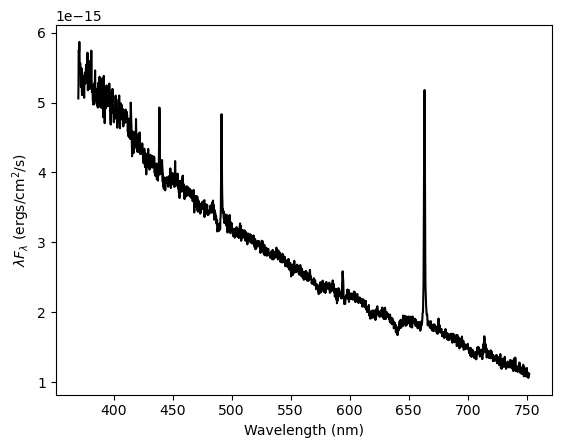

In [5]:
#Plot supernova lightcurve
plt.plot(SN.wavelen, SN.flambda, 'k')
plt.xlabel('Wavelength (nm)')
plt.ylabel('$\lambda F_\lambda$ (ergs/cm$^2$/s)')

In [6]:
# Read in the total ('final') throughput curves in each filter, and the atmosphere curve.
filterdir = os.path.dirname('/Users/andresponte/rubin_sim_data/throughputs/baseline/')
lsst = {}
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
filtercolors = {'u':'b', 'g':'c', 'r':'g', 'i':'orange', 'z':'r', 'y':'m'}
for f in filterlist:
    lsst[f] = Bandpass()
    lsst[f].readThroughput(os.path.join(filterdir, 'total_'+f+'.dat'))
atmos = Bandpass()
atmos.readThroughput(os.path.join(filterdir, 'atmos_std.dat'))#

In [7]:
# Calculate expected AB magnitudes. 
mags = {}
for f in filterlist:
    mags[f] = SN.calcMag(lsst[f])
    print('%s  %.2f' % (f, mags[f]))

u  nan
g  nan
r  nan
i  nan
z  nan
y  nan


/Users/andresponte/rubin_sim/rubin_sim/photUtils/Sed.py:870: UserWarning: There is an area of non-overlap between desired wavelength range  (300.00 to 1150.00)and sed FromArray (370.00 to 752.05)
  warnings.warn(


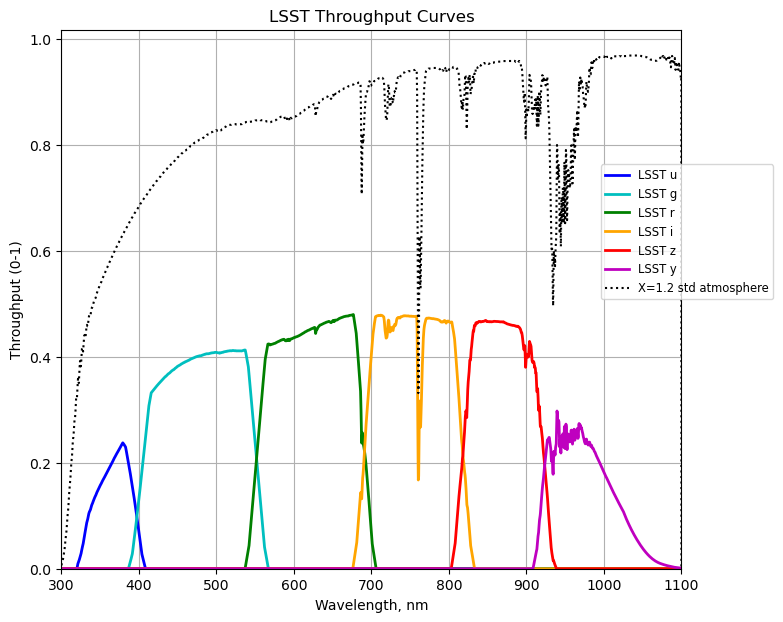

In [8]:
# Plot these curves alone.
plt.figure(figsize=(8,7))
for f in filterlist:
    plt.plot(lsst[f].wavelen, lsst[f].sb, color=filtercolors[f], lw=2, label='LSST %s' % (f))
plt.plot(atmos.wavelen, atmos.sb, 'k:', label='X=1.2 std atmosphere')
plt.xlabel('Wavelength, nm')
plt.ylabel('Throughput (0-1)')
plt.title('LSST Throughput Curves')
plt.xlim(300, 1100)
plt.legend(loc=(0.87, 0.5), fancybox=True, fontsize='smaller')
plt.grid(True)
plt.ylim(bottom=0)
plt.savefig(os.path.join(filterdir, 'LSSTfilters.png'), format='png')

Text(0, 0.5, 'Flux (ergs/cm$^2$/s)')

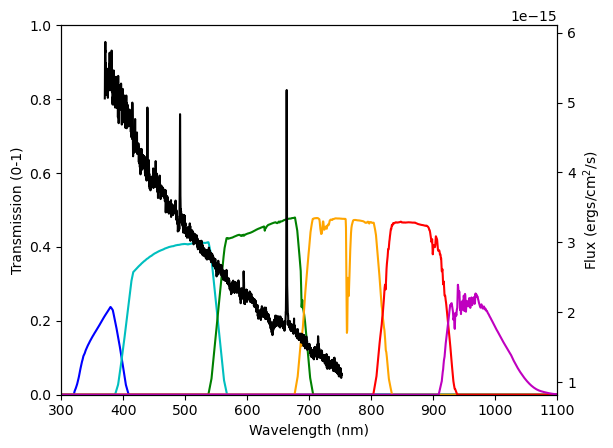

In [9]:
#Plot Throughput curves with SN lightcurve

fig = plt.figure()
ax1 = plt.subplot(1,1,1)
ax2 = ax1.twinx()
for f in filterlist:
    ax1.plot(lsst[f].wavelen, lsst[f].sb, color=filtercolors[f])
ax2.plot(SN.wavelen, SN.flambda, 'k')
plt.xlim(300, 1100)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Transmission (0-1)')
ax1.set_ylim(0, 1)
ax2.set_ylabel('Flux (ergs/cm$^2$/s)')

In [10]:
#Multiply Lightcurves by throughput 
SN_filtered = SN.calcErgs(lsst['i'])
print(SN_filtered)


nan


In [11]:
wavelen, flambda = SN.resampleSED(
            wavelen=SN.wavelen, flux=SN.flambda, wavelen_match=lsst['g'].wavelen
        )
print(wavelen, flambda)

[ 300.   300.1  300.2 ... 1149.8 1149.9 1150. ] [nan nan nan ... nan nan nan]


In [56]:
a = np.linspace(200, 1200, 100000)
b = np.linspace(1e-22, 5e-22, 100000)
SNtest = Sed()
SNtest.setSED(a, b)
print(SNtest.wavelen)
print(SNtest.flambda)

[ 200.         200.0100001  200.0200002 ... 1199.9799998 1199.9899999
 1200.       ]
[1.00000e-22 1.00004e-22 1.00008e-22 ... 4.99992e-22 4.99996e-22
 5.00000e-22]


Text(0, 0.5, 'Flux (ergs/cm$^2$/s)')

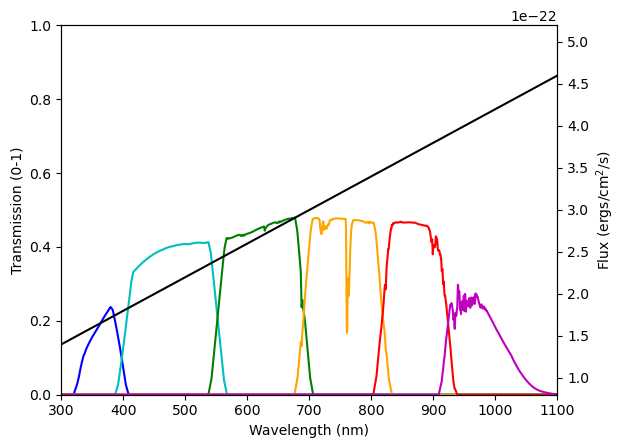

In [57]:
#Plot Throughput curves with SN lightcurve

fig = plt.figure()
ax1 = plt.subplot(1,1,1)
ax2 = ax1.twinx()
for f in filterlist:
    ax1.plot(lsst[f].wavelen, lsst[f].sb, color=filtercolors[f])
ax2.plot(SNtest.wavelen, SNtest.flambda, 'k')
plt.xlim(300, 1100)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Transmission (0-1)')
ax1.set_ylim(0, 1)
ax2.set_ylabel('Flux (ergs/cm$^2$/s)')

In [58]:
# Calculate expected AB magnitudes. 
mags = {}
for f in filterlist:
    mags[f] = SNtest.calcMag(lsst[f])
    print('%s  %.2f' % (f, mags[f]))

u  36.71
g  35.87
r  35.04
i  34.44
z  33.98
y  33.62


In [67]:
# Calculate expected AB magnitudes. 
SN_filteredtest = {}
for f in filterlist:
    SN_filteredtest[f] = SNtest.calcErgs(lsst[f])
    print(f, SN_filteredtest[f])

u 2.0349421489312874e-21
g 1.2304811666569907e-20
r 1.6824745173657377e-20
i 1.8666233398296593e-20
z 1.714420770005975e-20
y 1.0329467670980505e-20


In [ ]:
#Convert to absolute magnitude

In [ ]:
#Convert to apparent magnitude

In [ ]:
#Read in background data

In [ ]:
#Plot lightcurves and background subtracted lightcurves.